# Data exploring and preprocessing

In [197]:
import pandas as pd
# read the data first
data = pd.read_csv('./data.csv')
data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [198]:
data.shape

(569, 33)

In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [200]:
data['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [201]:
col = data.columns
data.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
data = data.dropna()
# data.shape
data['label'] = data['diagnosis'].map({'M': 1, 'B': 0}) # prepare the binary label
data.drop(['diagnosis'], axis=1, inplace=True)

# Prepare the training set, validation set and testing set, ratio as 6:2:2

In [202]:
from sklearn.model_selection import train_test_split
random_seed = 888
data_train, data_rest = train_test_split(data, test_size=0.4, random_state=random_seed, stratify=data['label'])
data_test, data_validate = train_test_split(data_rest, test_size=0.5, random_state=random_seed, stratify=data_rest['label']) 

In [203]:
print(data_train.shape)
print(data_validate.shape)
print(data_test.shape)

(341, 31)
(114, 31)
(114, 31)


In [204]:
# check if the splitting is balanced
print(data_train['label'].value_counts())
print(data_validate['label'].value_counts())
print(data_test['label'].value_counts())

label
0    214
1    127
Name: count, dtype: int64
label
0    72
1    42
Name: count, dtype: int64
label
0    71
1    43
Name: count, dtype: int64


# Normalization of three sets

In [205]:
from sklearn.preprocessing import MinMaxScaler
def get_features_and_target_arrays(input_df):
    y = input_df['label']
    x = input_df.drop(['label'], axis=1)
    scaler = MinMaxScaler()
    x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
    return x_scaled, y

In [206]:
X_train, y_train = get_features_and_target_arrays(data_train)
X_test, y_test = get_features_and_target_arrays(data_test)
X_validate, y_validate = get_features_and_target_arrays(data_validate)

# Find the optimal hyperparameter C using the validation data with grid search

In [207]:
X_train


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
116,0.037863,0.253669,0.051393,0.018850,0.390680,0.321821,0.217034,0.114712,0.055525,0.473247,...,0.019108,0.134595,0.038749,0.009987,0.307080,0.202778,0.123323,0.134147,0.020670,0.237067
107,0.209099,0.370231,0.199576,0.115276,0.270836,0.149592,0.061926,0.095477,0.217202,0.233675,...,0.179419,0.412313,0.167449,0.101540,0.311269,0.213869,0.154712,0.294454,0.336897,0.179671
439,0.292458,0.249476,0.276921,0.176135,0.208663,0.111742,0.048899,0.131809,0.210125,0.128849,...,0.246422,0.194296,0.230988,0.149905,0.185589,0.088965,0.050000,0.286571,0.135662,0.128901
195,0.236718,0.277568,0.225309,0.136912,0.205621,0.105147,0.090745,0.118141,0.340773,0.146539,...,0.203822,0.265991,0.197857,0.120412,0.238375,0.153529,0.140895,0.287234,0.346638,0.154446
136,0.176459,0.291824,0.168214,0.096513,0.518190,0.127508,0.084161,0.129225,0.074034,0.207250,...,0.181074,0.358742,0.170924,0.102408,0.384164,0.090417,0.083546,0.243042,0.034925,0.196558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,0.352717,0.876730,0.377878,0.224196,0.514539,0.580701,0.597470,0.468638,0.503538,0.470845,...,0.354372,0.820096,0.417318,0.225425,0.506494,1.000000,0.934505,0.821765,0.599667,0.917700
50,0.178970,0.498532,0.168214,0.098385,0.290303,0.092878,0.038824,0.055417,0.158955,0.194802,...,0.166598,0.365139,0.152505,0.092321,0.228320,0.068433,0.044113,0.129578,0.206225,0.113189
227,0.341669,0.243187,0.334381,0.210091,0.257939,0.276731,0.152413,0.187873,0.369080,0.198952,...,0.308462,0.194296,0.333333,0.189752,0.271052,0.433574,0.271725,0.480991,0.330007,0.305472
566,0.422015,0.770231,0.413700,0.285665,0.268159,0.254340,0.216753,0.263519,0.210670,0.142389,...,0.414757,0.589019,0.405734,0.295234,0.273565,0.363199,0.271805,0.494594,0.155144,0.247542


In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define logistic regression model
logistic_reg = LogisticRegression(solver='liblinear') # liblinear is better for data of small size

# Define hyperparameters grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e10]}  # 'C' is the inverse of lambda

# Create grid search object, using f1 score here to find a balance between recall and precision
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_validate, y_validate)

# Get the best hyperparameter
best_hyperparameter = grid_search.best_params_['C']

print("Best hyperparameter:", best_hyperparameter)

Best hyperparameter: 1000


# Visualize the grid search for optimal hyperparameter

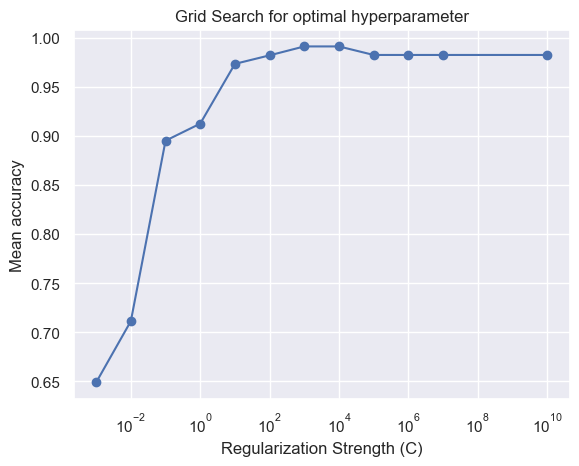

In [212]:
import numpy as np
import matplotlib.pyplot as plt

# Extract grid search results
results = grid_search.cv_results_
mean_test_scores = np.array(results['mean_test_score']).reshape(12, 1)

# Create a basic plot
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e10], mean_test_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean accuracy')
plt.title('Grid Search for optimal hyperparameter')
plt.grid(True)
plt.show()


# Train the model using the best hyperparameter learnt

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Initialize logistic regression model with the optimal hyperparameter value
logistic_reg = LogisticRegression(solver='liblinear', C=best_hyperparameter, penalty='l2')

# Train the model on the entire training dataset
logistic_reg.fit(X_train, y_train)

# Predict the labels on the test dataset
y_pred_test = logistic_reg.predict(X_test)
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_test)
# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9122807017543859


# Plot the precision and recall curve, ROC curve and the f1 threshold curve

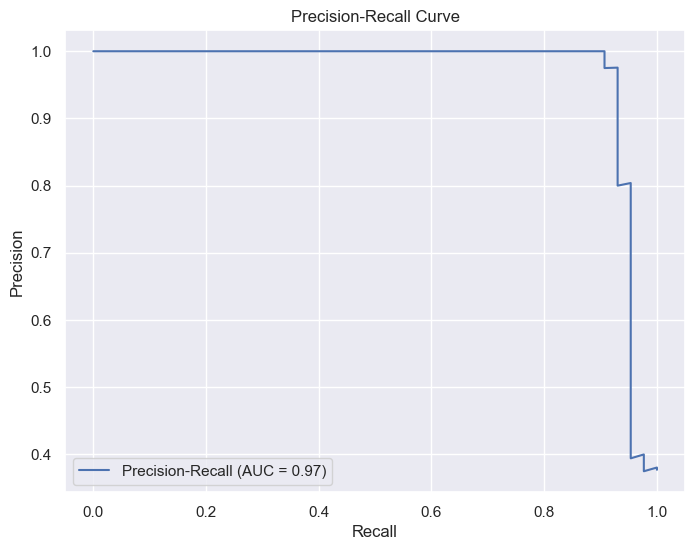

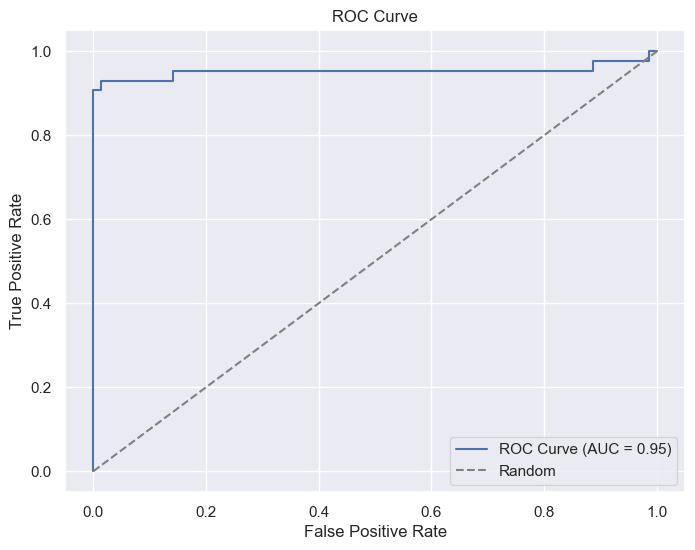

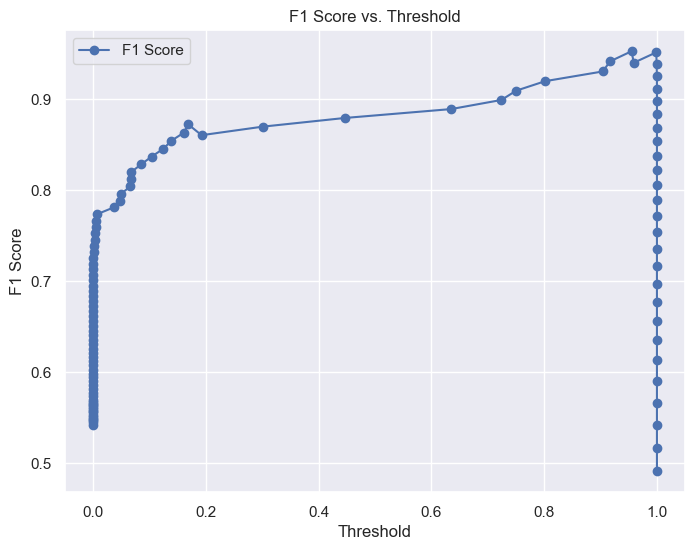

In [214]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_pred_prob = logistic_reg.predict_proba(X_test)[:, 1]

# Compute precision and recall
precision, recall, thresholds  = precision_recall_curve(y_test, y_pred_prob)

# Compute F1 score
f1 = 2 * (precision * recall) / (precision + recall)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Compute area under the curves (AUC)
pr_auc = auc(recall, precision)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Plot F1 score with respect to different threshold values
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1[:-1], label='F1 Score', marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()

plt.show()